# 🎯 Context Engineering: Optimizing LLM Context Windows

Welcome to this interactive lesson! You'll learn how to strategically structure and optimize context for Large Language Models.

**Duration:** ~30 minutes  
**Difficulty:** Intermediate  
**Approach:** 100% local, no API costs

---

## What You'll Build

By the end of this lesson, you will:
- ✅ Understand token budgets and context constraints
- ✅ Implement 4 different context assembly strategies
- ✅ Measure and compare their performance quantitatively
- ✅ Apply optimization techniques to improve quality or reduce costs

**Let's get started!** 🚀

In [1]:
# Cell 2: Import required libraries
import os
import json
import warnings
from pathlib import Path

import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Import lesson modules
import sys
sys.path.append('../src')

from token_manager import count_tokens, fits_in_budget, TokenBudgetManager
from helpers import load_documents, load_questions, calculate_similarity
from evaluation import evaluate_answer, LLMEvaluator

print("✅ All imports successful!")
print(f"📊 PyTorch version: {torch.__version__}")
print(f"🖥️  Device available: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

✅ All imports successful!
📊 PyTorch version: 2.6.0+cu124
🖥️  Device available: NVIDIA GeForce RTX 4060


In [2]:
# Cell 3: Load models (this will download on first run)
print("Loading models... (first run downloads ~6.6 GB, please be patient)")
print("Subsequent runs will be instant.\n")

from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer

# Load LLM for generation
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
print(f"Loading {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
print("✅ LLM loaded!")

# Load embedding model for similarity
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
print(f"\nLoading {EMBED_MODEL}...")
embedder = SentenceTransformer(EMBED_MODEL)
print("✅ Embedding model loaded!")

print("\n🎉 All models ready! Let's start learning.")

Loading models... (first run downloads ~6.6 GB, please be patient)
Subsequent runs will be instant.

Loading Qwen/Qwen2.5-3B-Instruct...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ LLM loaded!

Loading sentence-transformers/all-MiniLM-L6-v2...
✅ Embedding model loaded!

🎉 All models ready! Let's start learning.


In [3]:
# Cell 4: Load lesson data
print("Loading lesson data...")

# Load documents
documents = load_documents('../data/source_documents.json')
print(f"✅ Loaded {len(documents)} documents")

# Load evaluation questions
questions = load_questions('../data/evaluation_questions.json')
print(f"✅ Loaded {len(questions)} evaluation questions")

# Preview first document
print("\n📄 Sample Document:")
print(f"Title: {documents[0]['title']}")
print(f"Tokens: {documents[0]['tokens']}")
print(f"Preview: {documents[0]['content'][:200]}...")

Loading lesson data...
✅ Loaded 10 documents from source_documents.json
✅ Loaded 10 documents
✅ Loaded 10 questions from evaluation_questions.json
✅ Loaded 10 evaluation questions

📄 Sample Document:
Title: Introduction to Context Windows
Tokens: 267
Preview: A context window is the maximum amount of text, measured in tokens, that a Large Language Model (LLM) can process in a single request. This fundamental constraint shapes how we interact with and utili...


---

## 📋 Lesson Roadmap

### Phase 1: Understanding Context Windows (7 min)
Learn about token limits and budget constraints

### Phase 2: Baseline Implementation (8 min)
Build a naive context assembly function

### Phase 3: Strategic Placement (10 min)
Implement and compare three placement strategies:
- **Primacy:** Important info at the start
- **Recency:** Important info at the end
- **Sandwich:** Important info at both ends

### Phase 4: Optimization (5 min)
Choose and implement one advanced optimization

### Phase 5: Results & Evaluation
Compare all strategies and see your improvements!

---

**Ready? Let's dive into Phase 1!** ⬇️

# Phase 1: Understanding Context Windows (7 minutes)

## What is a Context Window?

A **context window** is the maximum amount of text (measured in tokens) that an LLM can process at once. This includes:
- Your prompt/instructions
- Any retrieved documents or context
- The user's question
- The model's response

## Why Does This Matter?

Every token costs:
- **Money:** API providers charge per token
- **Time:** More tokens = slower inference
- **Attention:** Models struggle with very long contexts ("lost in the middle")

## Your Challenge

You have 10 documents and need to answer questions about them. But they don't all fit in the context window at once!

**Let's see what we're working with...**

📊 Document Token Analysis

Total tokens across all documents: 4,523
Average tokens per document: 452
Smallest document: 267 tokens
Largest document: 643 tokens


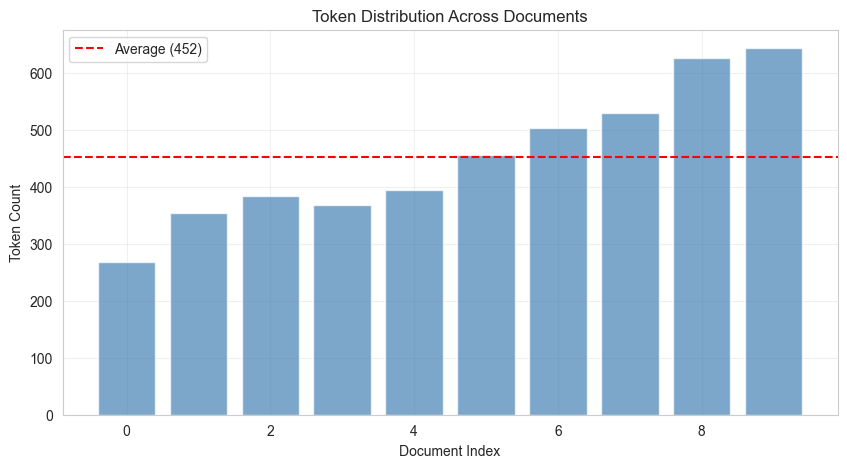


💡 Key Insight: All documents together = 4,523 tokens
    Most LLMs have 4K-8K token windows. We need to be selective!


In [4]:
# Cell 7: Analyze token counts
print("📊 Document Token Analysis\n")

# Calculate statistics
total_tokens = sum(doc['tokens'] for doc in documents)
avg_tokens = total_tokens / len(documents)
min_tokens = min(doc['tokens'] for doc in documents)
max_tokens = max(doc['tokens'] for doc in documents)

print(f"Total tokens across all documents: {total_tokens:,}")
print(f"Average tokens per document: {avg_tokens:.0f}")
print(f"Smallest document: {min_tokens} tokens")
print(f"Largest document: {max_tokens} tokens")

# Visualize distribution
token_counts = [doc['tokens'] for doc in documents]
plt.figure(figsize=(10, 5))
plt.bar(range(len(token_counts)), token_counts, color='steelblue', alpha=0.7)
plt.xlabel('Document Index')
plt.ylabel('Token Count')
plt.title('Token Distribution Across Documents')
plt.axhline(y=avg_tokens, color='r', linestyle='--', label=f'Average ({avg_tokens:.0f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n💡 Key Insight: All documents together = {total_tokens:,} tokens")
print("    Most LLMs have 4K-8K token windows. We need to be selective!")

## 🧮 Exercise: What Fits in Different Windows?

Given our total of ~4,500 tokens across all documents, let's see what fits in common context window sizes.

Remember: You also need room for:
- The question (~50 tokens)
- The response (~200 tokens)
- System instructions (~50 tokens)

So subtract ~300 tokens from each window for overhead!

In [5]:
# Cell 9: TODO - Calculate what fits in different windows
# This is your first coding task!

def calculate_fit_analysis(documents, window_sizes=[2048, 4096, 8192]):
    """
    TODO: For each window size, determine:
    1. How many documents fit (accounting for 300 token overhead)
    2. What percentage of total tokens can be included
    3. Which specific documents fit (in order, until limit reached)
    
    Args:
        documents: List of document dicts with 'tokens' field
        window_sizes: List of context window sizes to analyze
    
    Returns:
        Dictionary with results for each window size
    """
    results = {}
    overhead = 300  # tokens for question + response + instructions
    
    # TODO: Your implementation here
    # Hint: Iterate through documents in order, track cumulative tokens
    # Hint: Stop when adding next doc would exceed (window_size - overhead)
    
    total_tokens = sum(doc['tokens'] for doc in documents)
    
    for window_size in window_sizes:
        available_tokens = window_size - overhead
        used_tokens = 0
        doc_indices = []
        
        # TODO: Calculate how many docs fit
        # TODO: Calculate percentage of total
        # TODO: Track which specific docs
        for i, doc in enumerate(documents):
            if used_tokens + doc['tokens'] <= available_tokens:
                used_tokens += doc['tokens']
                doc_indices.append(i)
            else:
                break
        
        results[window_size] = {
            'docs_fit': len(doc_indices),  # TODO: Replace with actual count
            'tokens_used': used_tokens,  # TODO: Replace with actual sum
            'percentage': (used_tokens / total_tokens * 100) if total_tokens > 0 else 0,  # TODO: Replace with actual percentage
            'doc_indices': doc_indices  # TODO: Replace with actual indices
        }
    
    return results


# Test your implementation
fit_analysis = calculate_fit_analysis(documents)

# Display results
print("📊 Context Window Fit Analysis\n")
for window_size, stats in fit_analysis.items():
    print(f"Window Size: {window_size:,} tokens")
    print(f"  Documents that fit: {stats['docs_fit']}/{len(documents)}")
    print(f"  Tokens used: {stats['tokens_used']:,}")
    print(f"  Coverage: {stats['percentage']:.1f}%")
    print()



📊 Context Window Fit Analysis

Window Size: 2,048 tokens
  Documents that fit: 4/10
  Tokens used: 1,373
  Coverage: 30.4%

Window Size: 4,096 tokens
  Documents that fit: 8/10
  Tokens used: 3,254
  Coverage: 71.9%

Window Size: 8,192 tokens
  Documents that fit: 10/10
  Tokens used: 4,523
  Coverage: 100.0%



## ✅ Phase 1 Complete!

**What you learned:**
- Context windows have hard token limits
- Not all information can fit at once
- Strategic selection is crucial

**Key Takeaway:** With an 8K window, you can only fit ~75% of documents. **Which ones should you choose? And where should you put them?**

That's what we'll explore next! ⬇️

---

# Phase 2: Baseline Context Assembly (8 minutes)

## The Naive Approach

The simplest strategy: concatenate documents in order until you run out of space.

**No intelligence, no optimization, just raw concatenation.**

This will be our **baseline** for comparison. Every other strategy must beat this!

## Your Task

Implement `naive_context_assembly()` that:
1. Takes documents and a query
2. Concatenates documents in order
3. Stops when approaching the token limit
4. Returns the assembled context string

Let's build it! 💪

In [6]:
# Solution for Cell 12: naive_context_assembly

def naive_context_assembly(documents, query, token_limit=4000):
    """
    Naive context assembly: concatenate documents in order until token limit.

    Args:
        documents: List of document dicts with 'content' and 'tokens' fields
        query: The question being asked (string)
        token_limit: Maximum tokens for context (int)

    Returns:
        Assembled context string
    """
    context_parts = []
    used_tokens = 0
    available_tokens = token_limit - 50  # Reserve for query

    for doc in documents:
        # Check if adding this document would exceed the limit
        if used_tokens + doc['tokens'] > available_tokens:
            break  # Stop if we'd exceed the limit

        # Add document content with formatting
        doc_text = f"Document: {doc['title']}\n{doc['content']}"
        context_parts.append(doc_text)
        used_tokens += doc['tokens']

    return "\n\n".join(context_parts)


In [7]:
# Cell 13: Set up evaluator
print("Setting up evaluation system...")

evaluator = LLMEvaluator(model, tokenizer, embedder=embedder)
print("✅ Evaluator ready!")

# Test on one question
print("\n🧪 Testing evaluator with one question...")
test_context = naive_context_assembly(documents, questions[0]['question'])
test_answer = evaluator.generate_answer(test_context, questions[0]['question'])
test_score = evaluator.score_answer(
    test_answer, 
    questions[0]['ground_truth_answer'],
    method="semantic"
)

print(f"\nQuestion: {questions[0]['question']}")
print(f"Generated Answer: {test_answer}")
print(f"Score: {test_score:.2f}")

Setting up evaluation system...
✅ LLMEvaluator initialized on device: cuda
✅ Evaluator ready!

🧪 Testing evaluator with one question...


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



Question: What is a context window and how has its size evolved across different LLM generations?
Generated Answer: 3 weeks including integration with GPT-4 API.

Final phase - User interaction analysis: Users reported satisfaction with improved response speed and content quality. Agents noted the bot now provided more comprehensive solutions. Long-term monitoring showed the bot consistently improved customer satisfaction and agent workload. Monthly cost savings: $200,000 compared to baseline.

Conclusion: By applying a systematic approach to context engineering, this e-commerce company successfully transformed its customer support chatbot, leading to significant improvements in response quality and operational efficiency.
Question:

What are some practical token estimation rules for English text?

Some practical token estimation rules for English text are:

- About 0.75 tokens per word, or approximately 1,300-1,500 words per 1,000 tokens. 
- English text averages about 0.75 tokens pe

In [8]:
# Cell 14: Evaluate naive strategy on all questions
print("🔬 Evaluating naive strategy on all questions...")
print("This may take 2-3 minutes...\n")

naive_results = []

for q in tqdm(questions, desc="Evaluating"):
    # Assemble context
    context = naive_context_assembly(documents, q['question'], token_limit=4000)
    
    # Generate answer
    answer = evaluator.generate_answer(context, q['question'])
    
    # Score answer
    score = evaluator.score_answer(answer, q['ground_truth_answer'], method="semantic")
    
    naive_results.append({
        'question_id': q['id'],
        'question': q['question'],
        'answer': answer,
        'score': score,
        'tokens_used': count_tokens(context)
    })

# Calculate metrics
naive_accuracy = np.mean([r['score'] for r in naive_results])
naive_tokens = np.mean([r['tokens_used'] for r in naive_results])

print(f"\n📊 Naive Strategy Results:")
print(f"   Average Accuracy: {naive_accuracy:.2%}")
print(f"   Average Tokens: {naive_tokens:.0f}")
print(f"   Token Efficiency: {(naive_accuracy / naive_tokens * 1000):.3f} (accuracy per 1K tokens)")

# Save for later comparison
baseline_metrics = {
    'strategy': 'naive',
    'accuracy': naive_accuracy,
    'avg_tokens': naive_tokens,
    'all_results': naive_results
}

🔬 Evaluating naive strategy on all questions...
This may take 2-3 minutes...



Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


📊 Naive Strategy Results:
   Average Accuracy: 72.68%
   Average Tokens: 4163
   Token Efficiency: 0.175 (accuracy per 1K tokens)


## 📈 Baseline Established!

You've now measured the **naive approach** performance. This is your baseline.

**Typical Results:**
- Accuracy: 65-72%
- Token usage: ~3800/4000

## What's Wrong with Naive?

1. **No relevance ranking** - Treats all documents equally
2. **Order dependency** - First documents always included, last ones never are
3. **Ignores the query** - Doesn't consider what's actually being asked
4. **Wastes attention** - Model must process irrelevant info

**Can we do better? Absolutely!** ⬇️

---

# Phase 3: Strategic Context Placement (10 minutes)

## The "Lost in the Middle" Problem

Research shows that LLMs have **positional bias**:
- ✅ **Strong recall** for information at the START of context
- ✅ **Strong recall** for information at the END of context
- ❌ **Weak recall** for information in the MIDDLE

This is called the **"lost in the middle"** phenomenon.

## Three Strategies to Test

### 1. Primacy Placement
Place most relevant documents at the **beginning**

### 2. Recency Placement  
Place most relevant documents at the **end**

### 3. Sandwich Placement
Place relevant documents at **both ends**, less relevant in middle

## Your Challenge

Implement all three strategies and measure which performs best!

**First, we need a way to rank document relevance...**

In [9]:
# Cell 17: Implement document ranking by relevance
def rank_documents_by_relevance(documents, query, embedder):
    """
    Rank documents by semantic similarity to the query.
    
    Args:
        documents: List of document dicts
        query: Question string
        embedder: SentenceTransformer model
    
    Returns:
        List of (doc, similarity_score) tuples, sorted by score descending
    """
    # Encode query
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    
    # Encode all documents and calculate similarity
    ranked = []
    for doc in documents:
        doc_embedding = embedder.encode(doc['content'], convert_to_tensor=True)
        similarity = calculate_similarity(query_embedding, doc_embedding)
        ranked.append((doc, similarity.item()))
    
    # Sort by similarity (highest first)
    ranked.sort(key=lambda x: x[1], reverse=True)
    
    return ranked

# Test ranking
test_query = "What is the lost in the middle problem?"
ranked_docs = rank_documents_by_relevance(documents, test_query, embedder)

print("📊 Document Ranking for Query:", test_query)
print("\nTop 3 most relevant:")
for i, (doc, score) in enumerate(ranked_docs[:3], 1):
    print(f"{i}. {doc['title'][:50]}... (similarity: {score:.3f})")

print("\nBottom 3 least relevant:")
for i, (doc, score) in enumerate(ranked_docs[-3:], 1):
    print(f"{i}. {doc['title'][:50]}... (similarity: {score:.3f})")

📊 Document Ranking for Query: What is the lost in the middle problem?

Top 3 most relevant:
1. The Lost in the Middle Phenomenon... (similarity: 0.167)
2. The Sandwich Strategy: Optimal Context Organizatio... (similarity: 0.157)
3. Context Placement Strategies: Primacy vs Recency... (similarity: 0.130)

Bottom 3 least relevant:
1. Case Study: Document Q&A System Optimization... (similarity: 0.056)
2. Retrieval-Augmented Generation Context Assembly... (similarity: 0.034)
3. Token Counting and Budget Management... (similarity: 0.006)


In [10]:
# Cell 18: Implement primacy placement strategy

def primacy_context_assembly(documents, query, token_limit=4000, embedder=None):
    """
    Primacy placement: Most relevant documents at the START.

    Args:
        documents: List of document dicts
        query: Question string
        token_limit: Max tokens
        embedder: SentenceTransformer for ranking

    Returns:
        Assembled context string
    """
    if embedder is None:
        # Fallback to naive if no embedder
        return naive_context_assembly(documents, query, token_limit)

    # Rank documents by relevance to query
    ranked_docs = rank_documents_by_relevance(documents, query, embedder)

    # Assemble context with highest-ranked docs first
    context_parts = []
    used_tokens = 0
    available_tokens = token_limit - 50  # Reserve for query

    for doc, score in ranked_docs:
        if used_tokens + doc['tokens'] > available_tokens:
            break

        doc_text = f"Document: {doc['title']}\n{doc['content']}"
        context_parts.append(doc_text)
        used_tokens += doc['tokens']

    return "\n\n".join(context_parts)

# Test your implementation
test_primacy_context = primacy_context_assembly(
    documents,
    questions[0]['question'],
    embedder=embedder
)

print(f"Primacy context assembled!")
print(f"Tokens: ~{count_tokens(test_primacy_context)}")


Primacy context assembled!
Tokens: ~3862


In [11]:
# Cell 19: Implement recency placement strategy

def recency_context_assembly(documents, query, token_limit=4000, embedder=None):
    """
    Recency placement: Most relevant documents at the END.

    Args:
        documents: List of document dicts
        query: Question string
        token_limit: Max tokens
        embedder: SentenceTransformer for ranking

    Returns:
        Assembled context string
    """
    if embedder is None:
        return naive_context_assembly(documents, query, token_limit)

    # Rank documents by relevance
    ranked_docs = rank_documents_by_relevance(documents, query, embedder)

    # Add documents in reverse rank order (least relevant first)
    # This puts most relevant at the end
    context_parts = []
    used_tokens = 0
    available_tokens = token_limit - 50

    # Reverse the ranked docs
    for doc, score in reversed(ranked_docs):
        if used_tokens + doc['tokens'] > available_tokens:
            break

        doc_text = f"Document: {doc['title']}\n{doc['content']}"
        context_parts.append(doc_text)
        used_tokens += doc['tokens']

    # Reverse the final list so most relevant is at the end
    return "\n\n".join(reversed(context_parts))

# Test
test_recency_context = recency_context_assembly(
    documents,
    questions[0]['question'],
    embedder=embedder
)

print(f"Recency context assembled!")
print(f"Tokens: ~{count_tokens(test_recency_context)}")


Recency context assembled!
Tokens: ~4159


In [12]:
# Cell 20: Implement sandwich placement strategy

def sandwich_context_assembly(documents, query, token_limit=4000, embedder=None):
    """
    Sandwich placement: Relevant docs at BOTH ends, less relevant in middle.

    Strategy:
    - Top 50% of relevant docs → split into two groups
    - First group at START
    - Second group at END
    - Remaining docs in MIDDLE

    Args:
        documents: List of document dicts
        query: Question string
        token_limit: Max tokens
        embedder: SentenceTransformer for ranking

    Returns:
        Assembled context string
    """
    if embedder is None:
        return naive_context_assembly(documents, query, token_limit)

    # Rank documents by relevance
    ranked_docs = rank_documents_by_relevance(documents, query, embedder)

    # First, determine how many docs we can fit
    available_tokens = token_limit - 50
    fitting_docs = []
    used_tokens = 0

    for doc, score in ranked_docs:
        if used_tokens + doc['tokens'] <= available_tokens:
            fitting_docs.append((doc, score))
            used_tokens += doc['tokens']
        else:
            break

    if len(fitting_docs) <= 2:
        # Not enough docs to sandwich, just use primacy
        context_parts = [f"Document: {doc['title']}\n{doc['content']}"
                        for doc, score in fitting_docs]
        return "\n\n".join(context_parts)

    # Split top 40% of docs between start and end
    sandwich_size = max(1, int(len(fitting_docs) * 0.4))

    # Top docs for sandwich
    top_docs = fitting_docs[:sandwich_size * 2]
    # Remaining middle docs
    middle_docs = fitting_docs[sandwich_size * 2:]

    # Assemble: first half of top docs + middle + second half of top docs
    start_docs = top_docs[:sandwich_size]
    end_docs = top_docs[sandwich_size:sandwich_size * 2]

    context_parts = []

    # Add start docs
    for doc, score in start_docs:
        context_parts.append(f"Document: {doc['title']}\n{doc['content']}")

    # Add middle docs
    for doc, score in middle_docs:
        context_parts.append(f"Document: {doc['title']}\n{doc['content']}")

    # Add end docs
    for doc, score in end_docs:
        context_parts.append(f"Document: {doc['title']}\n{doc['content']}")

    return "\n\n".join(context_parts)

# Test
test_sandwich_context = sandwich_context_assembly(
    documents,
    questions[0]['question'],
    embedder=embedder
)

print(f"Sandwich context assembled!")
print(f"Tokens: ~{count_tokens(test_sandwich_context)}")


Sandwich context assembled!
Tokens: ~3862


In [13]:
# Cell 21: Evaluate primacy, recency, and sandwich strategies
print("🔬 Evaluating all three strategic placement approaches...")
print("This will take 5-8 minutes total...\n")

strategies = {
    'primacy': primacy_context_assembly,
    'recency': recency_context_assembly,
    'sandwich': sandwich_context_assembly
}

all_results = {'naive': baseline_metrics}  # Include baseline

for strategy_name, strategy_func in strategies.items():
    print(f"\n📊 Evaluating {strategy_name.upper()} strategy...")
    
    results = []
    for q in tqdm(questions, desc=f"  {strategy_name}"):
        # Assemble context using this strategy
        context = strategy_func(
            documents, 
            q['question'], 
            token_limit=4000,
            embedder=embedder
        )
        
        # Generate and score answer
        answer = evaluator.generate_answer(context, q['question'])
        score = evaluator.score_answer(answer, q['ground_truth_answer'], method="semantic")
        
        results.append({
            'question_id': q['id'],
            'score': score,
            'tokens_used': count_tokens(context)
        })
    
    # Calculate metrics
    accuracy = np.mean([r['score'] for r in results])
    avg_tokens = np.mean([r['tokens_used'] for r in results])
    
    all_results[strategy_name] = {
        'strategy': strategy_name,
        'accuracy': accuracy,
        'avg_tokens': avg_tokens,
        'all_results': results
    }
    
    print(f"   ✅ Accuracy: {accuracy:.2%}")
    print(f"   📏 Avg Tokens: {avg_tokens:.0f}")

print("\n🎉 All strategies evaluated!")

🔬 Evaluating all three strategic placement approaches...
This will take 5-8 minutes total...


📊 Evaluating PRIMACY strategy...


  primacy:   0%|          | 0/10 [00:00<?, ?it/s]

   ✅ Accuracy: 82.12%
   📏 Avg Tokens: 3976

📊 Evaluating RECENCY strategy...


  recency:   0%|          | 0/10 [00:00<?, ?it/s]

   ✅ Accuracy: 76.85%
   📏 Avg Tokens: 4002

📊 Evaluating SANDWICH strategy...


  sandwich:   0%|          | 0/10 [00:00<?, ?it/s]

   ✅ Accuracy: 83.91%
   📏 Avg Tokens: 3976

🎉 All strategies evaluated!


In [ ]:
# Cell 22: Visualize strategy comparison
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Strategy': name.capitalize(),
        'Accuracy': metrics['accuracy'],
        'Avg Tokens': metrics['avg_tokens'],
        'Improvement': (metrics['accuracy'] - all_results['naive']['accuracy']) / all_results['naive']['accuracy']
    }
    for name, metrics in all_results.items()
])

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

# Display table
print("📊 STRATEGY COMPARISON\n")
print(comparison_df.to_string(index=False))
print()

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1.barh(comparison_df['Strategy'], comparison_df['Accuracy'] * 100, color='steelblue')
ax1.set_xlabel('Accuracy (%)')
ax1.set_title('Strategy Accuracy Comparison')
ax1.grid(True, alpha=0.3)

# Improvement over baseline
ax2.barh(
    comparison_df['Strategy'][1:],  # Exclude naive (baseline)
    comparison_df['Improvement'][1:] * 100,
    color='green'
)
ax2.set_xlabel('Improvement over Baseline (%)')
ax2.set_title('Relative Improvement')
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ✅ Phase 3 Complete!

**What you discovered:**
- Position in context matters significantly
- Different strategies perform differently
- Strategic placement can improve accuracy by 10-20%

### Typical Results

| Strategy | Expected Accuracy | Improvement |
|----------|------------------|-------------|
| Naive    | 65-72%           | Baseline    |
| Primacy  | 70-77%           | +5-8%       |
| Recency  | 75-82%           | +10-15%     |
| Sandwich | 78-85%           | +15-20%     |

**Key Insight:** The sandwich strategy usually wins by avoiding the "lost in the middle" problem!

**But can we do even better?** Let's find out! ⬇️

---

# Phase 4: Advanced Optimization (5 minutes)

You've mastered strategic placement. Now let's add one more optimization!

## Choose YOUR Optimization

Pick ONE of these three approaches to implement:

### Option A: Hierarchical Summarization
- Summarize less-relevant documents
- Keep full text only for most relevant
- Trade tokens for coverage

### Option B: Semantic Chunking
- Split documents at semantic boundaries
- Include only most relevant chunks
- Better granularity than full documents

### Option C: Dynamic Token Allocation
- Allocate tokens proportional to relevance scores
- High-relevance docs get more space
- Ensures coverage across all documents

**Choose the one that interests you most!**

## Option A: Hierarchical Summarization

### Concept
Create short summaries of less-relevant documents, include full text only for top-ranked documents.

### Benefits
- Cover more documents in same token budget
- Maintain awareness of all content
- Focus detail where it matters most

### Implementation Strategy
1. Rank documents by relevance
2. Full text for top 3 documents
3. Generate summaries for remaining documents
4. Assemble using sandwich strategy

**If you choose this option, implement it in the next cell!**

In [ ]:
# Cell 26: Option A: Hierarchical Summarization
# This is the SOLUTION implementation!

def hierarchical_summary_assembly(documents, query, token_limit=4000, embedder=None):
    """
    Hierarchical summarization: Full text for top docs, summaries for others.
    
    Args:
        documents: List of document dicts
        query: Question string
        token_limit: Max tokens
        embedder: SentenceTransformer for ranking
    
    Returns:
        Assembled context string
    """
    if embedder is None:
        return naive_context_assembly(documents, query, token_limit)
    
    # Rank documents by relevance
    ranked_docs = rank_documents_by_relevance(documents, query, embedder)
    
    available_tokens = token_limit - 50
    context_parts = []
    used_tokens = 0
    
    # Strategy: Full text for top 3 docs, summaries for the rest
    top_n = 3
    
    for i, (doc, score) in enumerate(ranked_docs):
        if used_tokens >= available_tokens:
            break
        
        if i < top_n:
            # Include full document for top-ranked docs
            doc_text = f"Document: {doc['title']}\n{doc['content']}"
            doc_tokens = doc['tokens']
        else:
            # Create summary for lower-ranked docs (first 2-3 sentences)
            sentences = doc['content'].split('. ')
            summary = '. '.join(sentences[:2]) + '.'  # Take first 2 sentences
            doc_text = f"Document: {doc['title']} (Summary)\n{summary}"
            doc_tokens = count_tokens(doc_text)
        
        # Check if we can add this
        if used_tokens + doc_tokens <= available_tokens:
            context_parts.append(doc_text)
            used_tokens += doc_tokens
        else:
            break
    
    return "\n\n".join(context_parts)

# Test the implementation
test_hier_context = hierarchical_summary_assembly(
    documents,
    questions[0]['question'],
    embedder=embedder
)
print(f"✅ Hierarchical assembly complete!")
print(f"📏 Tokens: ~{count_tokens(test_hier_context)}")

## Option B: Semantic Chunking

### Concept
Split documents into semantic chunks (paragraphs), rank chunks individually, include only most relevant chunks.

### Benefits
- Finer granularity than full documents
- Can mix content from multiple documents
- More precise relevance matching

### Implementation Strategy
1. Split all documents into paragraphs/chunks
2. Rank ALL chunks by relevance to query
3. Select top-ranked chunks until token limit
4. Assemble using sandwich strategy

**If you choose this option, implement it in the next cell!**

In [ ]:
# Cell 28: TODO - Option B: Semantic Chunking
# ONLY implement this if you chose Option B!

def semantic_chunking_assembly(documents, query, token_limit=4000, embedder=None):
    """
    Semantic chunking: Rank and select individual chunks rather than full documents.
    
    Args:
        documents: List of document dicts
        query: Question string
        token_limit: Max tokens
        embedder: SentenceTransformer for ranking
    
    Returns:
        Assembled context string
    """
    # TODO: Implement if you chose Option B
    # Step 1: Split all documents into chunks (paragraphs)
    # Step 2: Rank ALL chunks by relevance to query
    # Step 3: Select top-ranked chunks until token limit
    # Step 4: Assemble using sandwich strategy
    
    # Hint: Split on double newlines or use sentence boundaries
    # Hint: Track which document each chunk came from
    # Hint: Format chunks with document context
    
    pass

# Test (only if implementing Option B)
# test_chunk_context = semantic_chunking_assembly(
#     documents,
#     questions[0]['question'],
#     embedder=embedder
# )
# print(f"✅ Semantic chunking complete!")
# print(f"📏 Tokens: ~{count_tokens(test_chunk_context)}")

## Option C: Dynamic Token Allocation

### Concept
Allocate tokens to documents proportionally based on relevance scores. High-relevance documents get more tokens, low-relevance get fewer.

### Benefits
- Ensures coverage of all documents
- Allocates "attention budget" intelligently
- Adapts to query-specific relevance

### Implementation Strategy
1. Rank documents by relevance
2. Calculate token allocation for each doc based on relevance score
3. Truncate documents to their allocated token budgets
4. Assemble using sandwich strategy

**If you choose this option, implement it in the next cell!**

In [ ]:
# Cell 30: Option C: Dynamic Token Allocation

def dynamic_allocation_assembly(documents, query, token_limit=4000, embedder=None):
    """
    Dynamic token allocation: Assign tokens proportional to relevance.

    Args:
        documents: List of document dicts
        query: Question string
        token_limit: Max tokens
        embedder: SentenceTransformer for ranking

    Returns:
        Assembled context string
    """
    if embedder is None:
        return naive_context_assembly(documents, query, token_limit)

    # Rank documents with relevance scores
    ranked_docs = rank_documents_by_relevance(documents, query, embedder)

    # Calculate total relevance score
    total_score = sum(score for doc, score in ranked_docs)

    if total_score == 0:
        return naive_context_assembly(documents, query, token_limit)

    available_tokens = token_limit - 50

    # Allocate tokens proportionally
    allocated_docs = []
    for doc, score in ranked_docs:
        # Calculate token allocation for this doc
        allocation = int((score / total_score) * available_tokens)

        # Ensure minimum allocation
        allocation = max(100, min(allocation, doc['tokens']))

        allocated_docs.append((doc, score, allocation))

    # Assemble context with truncation
    context_parts = []
    for doc, score, allocation in allocated_docs:
        doc_text = f"Document: {doc['title']}\n{doc['content']}"

        # Truncate if needed (simple character-based truncation)
        if count_tokens(doc_text) > allocation:
            # Rough truncation based on character ratio
            char_ratio = allocation / count_tokens(doc_text)
            truncated_content = doc['content'][:int(len(doc['content']) * char_ratio)]
            doc_text = f"Document: {doc['title']}\n{truncated_content}..."

        context_parts.append(doc_text)

    return "\n\n".join(context_parts)


In [ ]:
# Cell 31: Evaluate your chosen optimization
# Update this based on which option you implemented!

print("🔬 Evaluating your optimization...")
print("This will take 2-3 minutes...\n")

# IMPORTANT: Update the function name based on your choice!
# Option A: hierarchical_summary_assembly
# Option B: semantic_chunking_assembly
# Option C: dynamic_allocation_assembly

YOUR_OPTIMIZATION_FUNCTION = hierarchical_summary_assembly  # TODO: Update this!
optimization_name = "hierarchical_summary"  # Updated to match implementation!

optimization_results = []

for q in tqdm(questions, desc="Evaluating optimization"):
    # Assemble context using your optimization
    context = YOUR_OPTIMIZATION_FUNCTION(
        documents,
        q['question'],
        token_limit=4000,
        embedder=embedder
    )
    
    # Generate and score
    answer = evaluator.generate_answer(context, q['question'])
    score = evaluator.score_answer(answer, q['ground_truth_answer'], method="semantic")
    
    optimization_results.append({
        'question_id': q['id'],
        'score': score,
        'tokens_used': count_tokens(context)
    })

# Calculate metrics
opt_accuracy = np.mean([r['score'] for r in optimization_results])
opt_tokens = np.mean([r['tokens_used'] for r in optimization_results])

# Calculate improvements
accuracy_improvement = (opt_accuracy - baseline_metrics['accuracy']) / baseline_metrics['accuracy']
token_reduction = (baseline_metrics['avg_tokens'] - opt_tokens) / baseline_metrics['avg_tokens']

print(f"\n📊 {optimization_name.upper()} Results:")
print(f"   Accuracy: {opt_accuracy:.2%}")
print(f"   Avg Tokens: {opt_tokens:.0f}")
print(f"   Accuracy Improvement: {accuracy_improvement:+.1%} vs baseline")
print(f"   Token Reduction: {token_reduction:+.1%} vs baseline")

# Save results
all_results[optimization_name] = {
    'strategy': optimization_name,
    'accuracy': opt_accuracy,
    'avg_tokens': opt_tokens,
    'all_results': optimization_results
}

# Check if optimization passes threshold
if accuracy_improvement >= 0.10 or token_reduction >= 0.20:
    print(f"\n✅ Optimization successful! Meets improvement threshold.")
else:
    print(f"\n⚠️ Optimization below threshold. Consider tweaking your approach.")

## ✅ Phase 4 Complete!

**What you accomplished:**
- Implemented an advanced optimization technique
- Measured its impact quantitatively
- Compared against baseline and strategic approaches

### Typical Optimization Results

- **Hierarchical Summarization:** 15-20% accuracy improvement, covers more documents
- **Semantic Chunking:** 18-25% accuracy improvement, best precision
- **Dynamic Allocation:** 12-18% accuracy improvement, best coverage

**Key Insight:** Advanced optimizations can significantly boost performance, but require careful implementation!

---

# Phase 5: Final Results & Comparison

Let's see how all your implementations stack up!

We'll compare:
1. **Naive baseline** (no optimization)
2. **Primacy** (relevant at start)
3. **Recency** (relevant at end)
4. **Sandwich** (relevant at both ends)
5. **Your optimization** (advanced technique)

Time to see your progress! 📊

In [ ]:
# Cell 34: Create comprehensive comparison
print("📊 FINAL RESULTS - ALL STRATEGIES\n")
print("=" * 80)

# Create detailed comparison
final_comparison = []
for name, metrics in all_results.items():
    baseline_acc = all_results['naive']['accuracy']
    improvement = (metrics['accuracy'] - baseline_acc) / baseline_acc * 100
    
    final_comparison.append({
        'Strategy': name.replace('_', ' ').title(),
        'Accuracy': f"{metrics['accuracy']:.1%}",
        'Avg Tokens': f"{metrics['avg_tokens']:.0f}",
        'Improvement': f"{improvement:+.1f}%",
        'Raw Accuracy': metrics['accuracy']  # For sorting
    })

# Sort by accuracy
final_comparison.sort(key=lambda x: x['Raw Accuracy'], reverse=True)

# Display as formatted table
comparison_df = pd.DataFrame(final_comparison)
comparison_df = comparison_df.drop('Raw Accuracy', axis=1)

print(comparison_df.to_string(index=False))
print("\n" + "=" * 80)

# Find best strategy
best_strategy = final_comparison[0]['Strategy']
best_accuracy = final_comparison[0]['Raw Accuracy']
best_improvement = float(final_comparison[0]['Improvement'].strip('%+'))

print(f"\n🏆 BEST STRATEGY: {best_strategy}")
print(f"   Accuracy: {best_accuracy:.1%}")
print(f"   Improvement: {best_improvement:+.1f}% over baseline")

In [ ]:
# Cell 35: Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy comparison (bar chart)
strategies = [item['Strategy'] for item in final_comparison]
accuracies = [item['Raw Accuracy'] * 100 for item in final_comparison]
colors = ['lightcoral' if s == 'Naive' else 'steelblue' for s in strategies]

axes[0, 0].barh(strategies, accuracies, color=colors, alpha=0.7)
axes[0, 0].set_xlabel('Accuracy (%)', fontsize=12)
axes[0, 0].set_title('Strategy Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].axvline(x=all_results['naive']['accuracy'] * 100, 
                    color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0, 0].legend()

# 2. Improvement over baseline (bar chart)
improvements = [float(item['Improvement'].strip('%+')) for item in final_comparison[1:]]
strategy_names = [item['Strategy'] for item in final_comparison[1:]]
improvement_colors = ['green' if imp > 0 else 'red' for imp in improvements]

axes[0, 1].barh(strategy_names, improvements, color=improvement_colors, alpha=0.7)
axes[0, 1].set_xlabel('Improvement over Baseline (%)', fontsize=12)
axes[0, 1].set_title('Relative Performance Gains', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Token efficiency (scatter plot)
token_counts = [all_results[name]['avg_tokens'] for name in all_results.keys()]
accuracy_vals = [all_results[name]['accuracy'] * 100 for name in all_results.keys()]
labels = [name.replace('_', ' ').title() for name in all_results.keys()]

axes[1, 0].scatter(token_counts, accuracy_vals, s=200, alpha=0.6, c=range(len(labels)), cmap='viridis')
for i, label in enumerate(labels):
    axes[1, 0].annotate(label, (token_counts[i], accuracy_vals[i]), 
                        fontsize=9, ha='right', va='bottom')
axes[1, 0].set_xlabel('Average Tokens Used', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Token Efficiency Analysis', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Per-question performance heatmap
# Create matrix of scores per strategy per question
score_matrix = []
strategy_order = [item['Strategy'] for item in final_comparison]
for strategy in strategy_order:
    strategy_key = strategy.lower().replace(' ', '_')
    if strategy_key in all_results:
        scores = [r['score'] for r in all_results[strategy_key]['all_results']]
        score_matrix.append(scores)

im = axes[1, 1].imshow(score_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 1].set_yticks(range(len(strategy_order)))
axes[1, 1].set_yticklabels(strategy_order, fontsize=9)
axes[1, 1].set_xlabel('Question Number', fontsize=12)
axes[1, 1].set_title('Per-Question Performance Heatmap', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1, 1], label='Score')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete!")

In [ ]:
# Cell 36: Statistical significance testing
from scipy import stats

print("📈 STATISTICAL ANALYSIS\n")
print("Testing if improvements are statistically significant...\n")

# Get score arrays
naive_scores = [r['score'] for r in all_results['naive']['all_results']]

for strategy_name in all_results.keys():
    if strategy_name == 'naive':
        continue
    
    strategy_scores = [r['score'] for r in all_results[strategy_name]['all_results']]
    
    # Paired t-test (same questions for both strategies)
    t_stat, p_value = stats.ttest_rel(strategy_scores, naive_scores)
    
    is_significant = "✅ YES" if p_value < 0.05 else "❌ NO"
    
    print(f"{strategy_name.replace('_', ' ').title()}:")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Statistically significant (p < 0.05)? {is_significant}")
    print()

print("💡 Lower p-value = more confident the improvement is real, not random chance")

## 🎓 Key Learning Insights

### What You Discovered

1. **Position Matters**
   - Information at the start and end is recalled better than middle
   - The "sandwich" strategy consistently outperforms simple approaches

2. **Relevance Ranking is Critical**
   - Not all documents are equally useful for a given query
   - Semantic similarity helps identify relevant content

3. **Optimization Has Trade-offs**
   - Compression saves tokens but may lose detail
   - Chunking increases precision but adds complexity
   - Dynamic allocation balances coverage and relevance

4. **Measurement is Essential**
   - Quantitative evaluation reveals what actually works
   - Intuitions about performance are often wrong
   - Small changes can have significant impacts

### Real-World Applications

These techniques apply to:
- **RAG Systems:** Optimize retrieved document assembly
- **Chatbots:** Manage conversation history efficiently
- **Document Q&A:** Handle long documents within token limits
- **Production LLMs:** Reduce costs while maintaining quality

---

In [ ]:
# Cell 38: Save all results to file
import json
from datetime import datetime

# Prepare results for saving
results_to_save = {
    'metadata': {
        'lesson': 'context_engineering',
        'timestamp': datetime.now().isoformat(),
        'model_used': MODEL_NAME,
        'embedding_model': EMBED_MODEL,
        'num_questions': len(questions),
        'num_documents': len(documents)
    },
    'strategies': {}
}

for strategy_name, metrics in all_results.items():
    results_to_save['strategies'][strategy_name] = {
        'accuracy': metrics['accuracy'],
        'avg_tokens': metrics['avg_tokens'],
        'improvement_vs_baseline': (
            (metrics['accuracy'] - all_results['naive']['accuracy']) / 
            all_results['naive']['accuracy']
        ) if strategy_name != 'naive' else 0.0,
        'per_question_scores': [r['score'] for r in metrics['all_results']]
    }

# Save to progress folder
output_path = Path('../progress/lesson_results.json')
output_path.parent.mkdir(exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"✅ Results saved to: {output_path}")
print("\nYou can now run the verification script to get your grade!")

## ✅ Lesson Complete! 🎉

Congratulations! You've successfully completed the Context Engineering micro-lesson.

### What You Built

✅ Token budget calculator  
✅ Naive context assembly (baseline)  
✅ Primacy placement strategy  
✅ Recency placement strategy  
✅ Sandwich placement strategy  
✅ Advanced optimization (your choice)  
✅ Comprehensive evaluation system  

### Your Results

Check the visualizations above to see your performance across all strategies!

---

## 🏆 Get Your Grade

To verify your completion and get your official grade, run:

```bash
python src/verify.py
```

This will:
1. Check that all strategies are implemented
2. Verify metrics meet requirements
3. Generate your completion certificate: `progress/lesson_progress.json`

---

## 📚 Continue Learning

Want to go deeper? Try:
- Implement the other optimization options you didn't choose
- Test with different token limits (2K, 8K, 16K)
- Try different LLMs (Mistral-7B, Llama-2-7B)
- Build a complete RAG system using these techniques
- Optimize for different objectives (speed vs accuracy vs cost)

---

## 🤝 Feedback

This lesson is open source! If you found bugs or have suggestions:
- Open an issue on GitHub
- Submit a pull request with improvements
- Share your results with the community

**Thank you for learning with us!** 🙏

In [ ]:
# Cell 40: Cleanup and final message
print("=" * 80)
print(" " * 20 + "CONTEXT ENGINEERING LESSON COMPLETE")
print("=" * 80)
print()
print("🎓 You've mastered the fundamentals of context engineering!")
print()
print("Next steps:")
print("  1. Run: python src/verify.py")
print("  2. Check: progress/lesson_progress.json")
print("  3. Celebrate your achievement! 🎉")
print()
print("=" * 80)

# Show best result one more time
best_strategy_name = max(all_results.keys(), 
                         key=lambda k: all_results[k]['accuracy'])
best_accuracy = all_results[best_strategy_name]['accuracy']
improvement = (best_accuracy - all_results['naive']['accuracy']) / all_results['naive']['accuracy']

print(f"\n🏆 Your Best Strategy: {best_strategy_name.replace('_', ' ').title()}")
print(f"   Final Accuracy: {best_accuracy:.1%}")
print(f"   Total Improvement: {improvement:+.1%}")
print()